In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

<table align="left">
  <td>
    <a target="_blank" 
        href="https://colab.research.google.com/github/evan-burke/m3_sf_2020_training/blob/master/how_ml_works.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

-----
# A machine can have a little learning, as a treat.
 

In [2]:
from dataclasses import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from IPython.display import Image, display # HTML

if IN_COLAB:
    from IPython.display import HTML
else:
    from IPython.display import Video

In [3]:
import matplotlib.style as style
style.use('fivethirtyeight')
FIGSIZE = (13,8)

In [4]:
# Generate some random points
np.random.seed(23580918)
x = np.random.rand(100, 1) * 10
noise = (np.random.randn(100, 1) + 0.7) * 0.5
Y_INTERCEPT = 1.3
SLOPE = 0.3
AVG_NOISE = np.mean(noise)
y = Y_INTERCEPT + SLOPE * x + noise

xmin = 0
xmax = 10
ymin = 0 
ymax = 6

In [5]:
def gen_random_line():   
    y_intercept_range = (0.3, 3)
    slope_range = (-0.1, 0.6)
    
    y_intercept = random.uniform(*y_intercept_range)
    slope = random.uniform(*slope_range)
    
    if slope <= -0.05 and y_intercept <0.1:
        # regenerate
        y_intercept, slope = gen_random_line()
            
    return y_intercept, slope


def compare_approx(x, y, threshold):
    if abs(x - y) < threshold:
        return True
    else:
        return False
    
def gen(chosen_vars):
    if chosen_vars is None:
        return gen_random_line()
    else:
        testvals = gen_random_line()
        for i in chosen_vars:
            if compare_approx(i.y_intercept, testvals[0], 0.3):
                if compare_approx(i.slope, testvals[1], 0.3):
                    # regenerate
                    return gen(chosen_vars)
        return testvals

In [6]:
@dataclass
class Line:
    color: str
    y_intercept: float
    slope: float
    cost: float = None

In [7]:
colors = ['b','g','r','c','m','y','k']
colormap = {'b':'blue',
            'g':'green',
            'r':'red',
            'c':'cyan',
            'm':'magenta',
            'y':'yellow',
            'k':'black'
           }
inverse_colormap = {}
for i in colormap:
    inverse_colormap[colormap[i]] = i

In [8]:
def plot_points(red=False, random_lines=None, lines=None, savefile=None):
    # relies on globals for vars x, y, colors
    
    _colors = random.sample(colors, len(colors))
    
    #compare_threshold = 0
    
    plt.figure(figsize=FIGSIZE)
    plt.scatter(x,y,s=55)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis((-0.03, 10.1, -0.03, 6)) #xmin, xmax, ymin, ymax
    
    if lines is not None:
        for i in lines:
            if i.color in inverse_colormap:
                color = inverse_colormap[i.color]
            else:
                color = i.color
            plt.plot(x, i.y_intercept + i.slope * x, color)

    chosen_vars = []
    if random_lines is not None:
        if random_lines > 7:
            random_lines = 7
            
        for i in range(random_lines):
            rl = gen(chosen_vars)
            randcolor = colors[i]
            chosen_vars.append(Line(colormap[randcolor], rl[0], rl[1]))
            plt.plot(x, rl[0] + rl[1] * x, randcolor)
    
    if red:
        plt.plot(x, Y_INTERCEPT + AVG_NOISE + SLOPE * x, "r")

    if savefile:
        plt.savefig(savefile)
        plt.close()
    else:
        plt.show()
    if chosen_vars:
        return chosen_vars

### Ok! We've got some data points. Let's look at them.

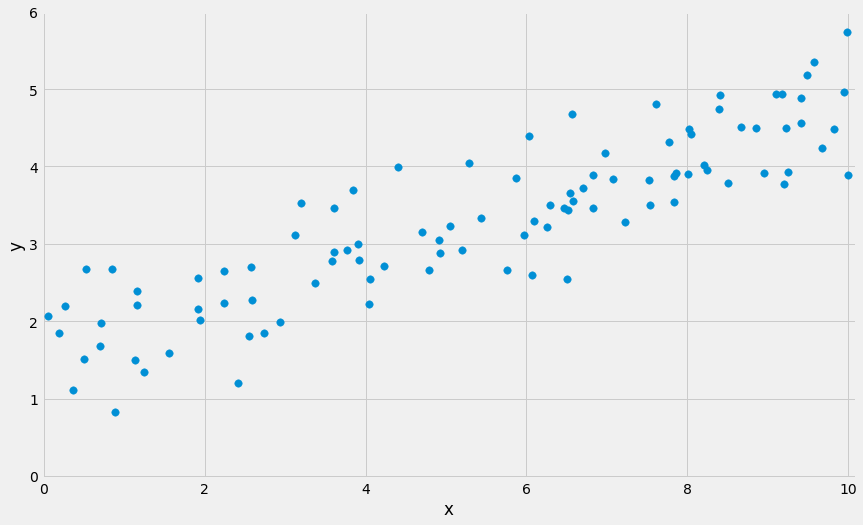

In [61]:
plot_points(0)

#### But software can't "see" the general shape in the same way we can.
#### It's more like this:

In [10]:
for i in range(50):
    print(x[i][0], y[i][0], sep="  \t")

9.824886792952027  	4.48920429201274
7.614293563673678  	4.802287378934495
6.978674980129168  	4.173454446748772
1.936041598735947  	2.0136530530756027
4.914338089223151  	3.052892131775596
9.989118582079097  	5.73969268387858
8.6679166394225  	4.507610919693362
6.099541474491854  	3.2973492968744202
6.833857182160652  	3.4666885433456596
3.6114497059205295  	2.8898412352428022
6.565332786261937  	4.678661461023332
9.422695762706736  	4.560874255654454
4.9208568809557995  	2.8775302833850733
9.201495353176144  	3.7743960971861537
6.5427038362258605  	3.6544958709079225
6.708138638571142  	3.720400281957546
7.543219731173149  	3.5049766128657773
8.053341337475771  	4.423364411638097
8.0107316584253  	3.9085177439656533
8.856036117658483  	4.496819519655672
9.573759826009857  	5.344513513714544
9.949238135741451  	4.957982160271245
5.869402897262168  	3.8563134023279195
8.245636960680413  	3.9581734962694908
9.674058181171876  	4.244427029094174
8.206366299502733  	4.023505819638344
1.15

Now, how might we write software try to approximate this process?
We could start generating lines at random and seeing how well they fit the data.

Which one looks best? Worst?

In [ ]:
random_lines = plot_points(0, 8)

If we want to figure out which one is closest, we need to have a way to score each of these lines.

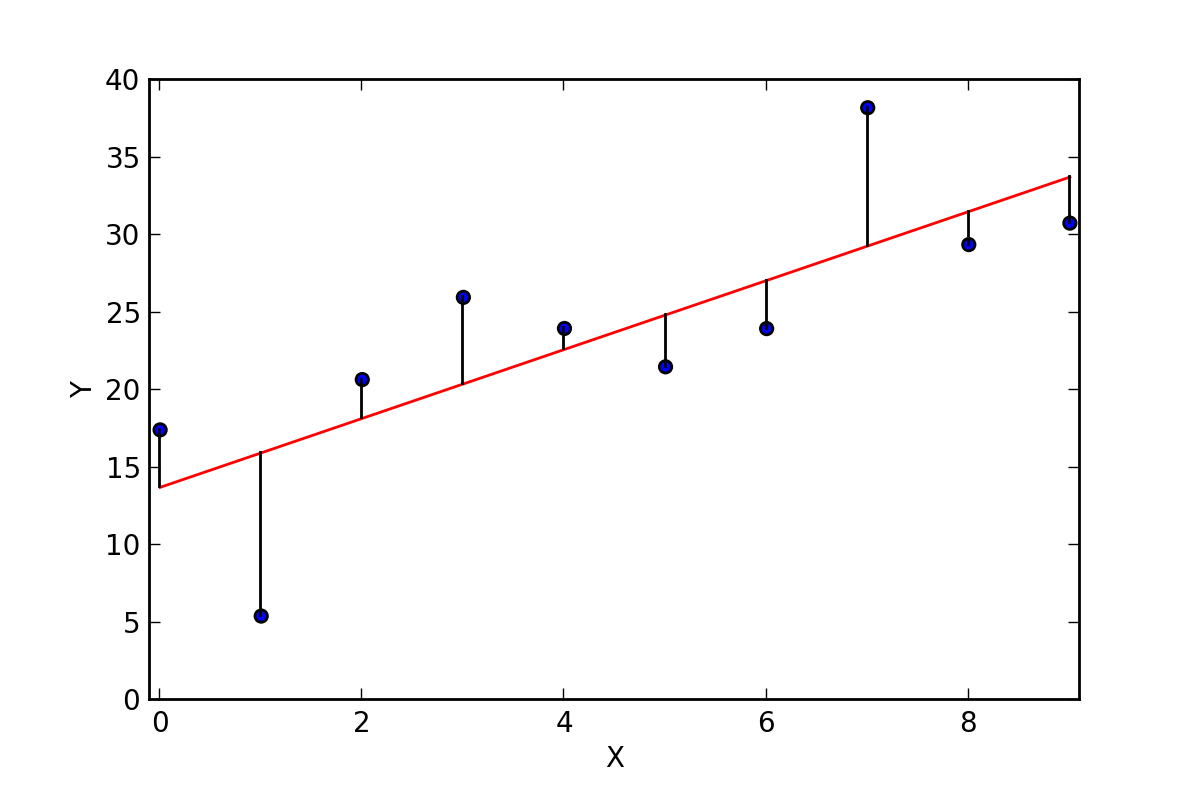

In [12]:
display(Image("https://iai-images.s3-us-west-2.amazonaws.com/m3_sf_2020/fit_errors.png"))



In [13]:
def line_equation(yi, slope, x):
    return yi + slope * x

def score(line):
    y_predict = []
    for i in x:
        y_predict.append(line_equation(line.y_intercept, line.slope, i))
    residuals = y_predict - y

    cost = np.sum((residuals ** 2)) / (2 * x.shape[0])
    return cost

def score_lines(lines):
    for n, i in enumerate(lines):
        cost = score(i)
        lines[n].cost = cost
    scores = sorted(lines, key=lambda i: i.cost)
    
    return scores, pd.DataFrame([asdict(i) for i in scores])

In [14]:
line_scores, df = score_lines(random_lines)
df.index = df['color']

In [ ]:
# Chart costs
df[['color','cost']].sort_values('cost', ascending=False).plot(kind="bar", figsize=(12,6))

In [62]:
# Show raw cost numbers
#df[['color','cost']]

In [ ]:
plot_points(lines=random_lines)

## A brief digression...

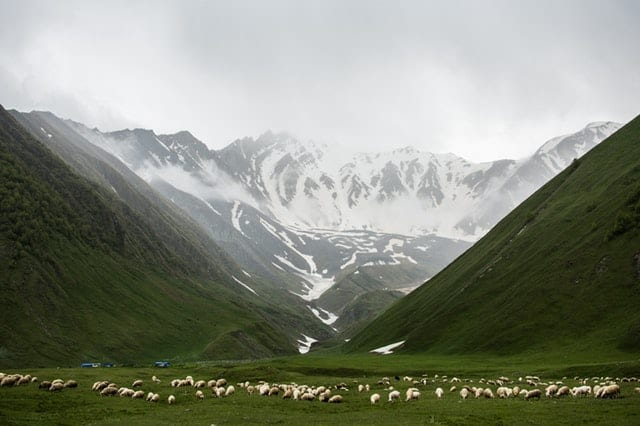

In [60]:
display(Image("https://iai-images.s3-us-west-2.amazonaws.com/m3_sf_2020/grass-field-near-mountains-valley.jpg", width=900))

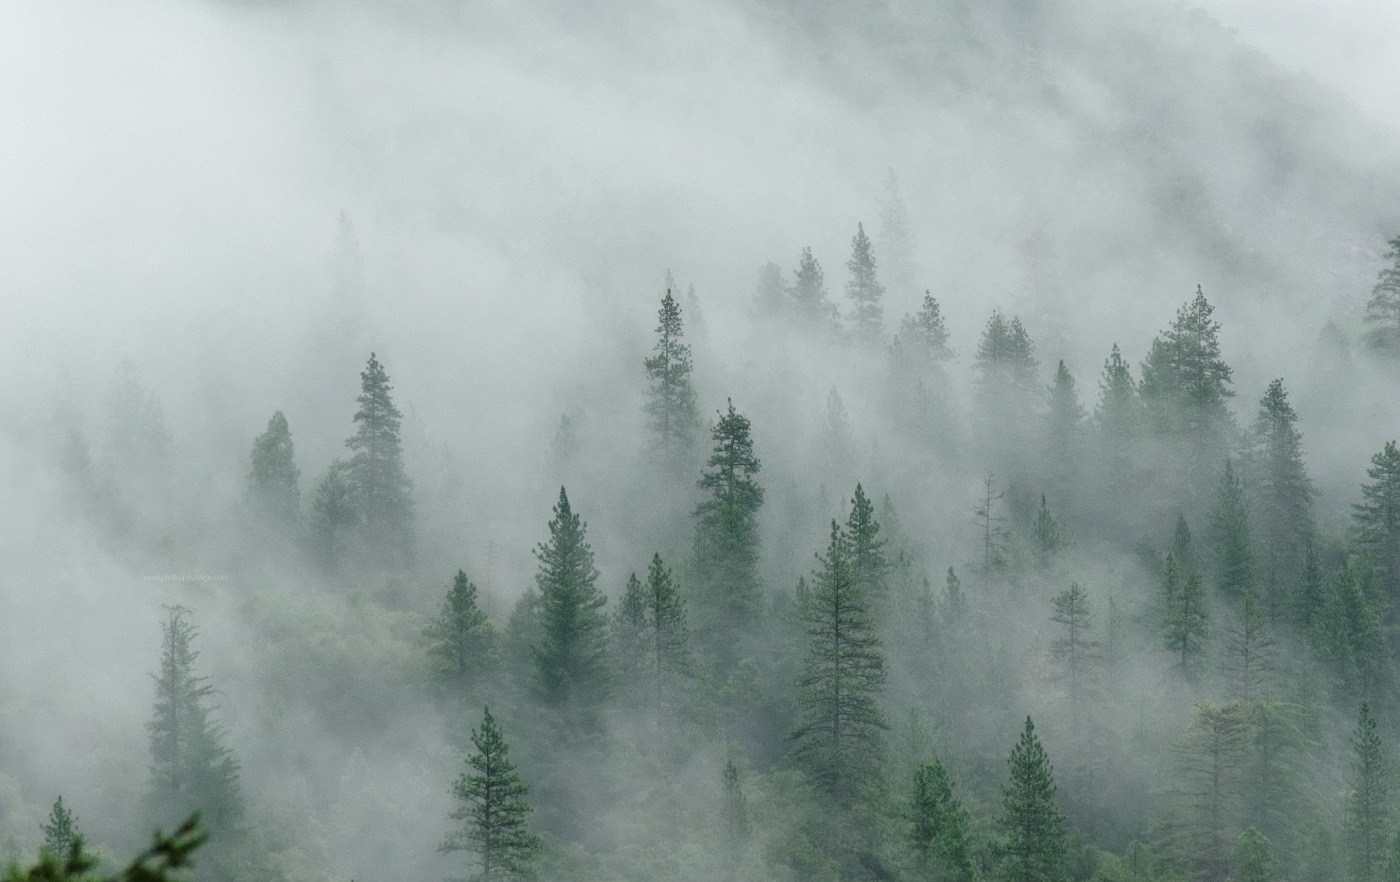

In [58]:
display(Image("https://iai-images.s3-us-west-2.amazonaws.com/m3_sf_2020/fog.jpg", width=900))

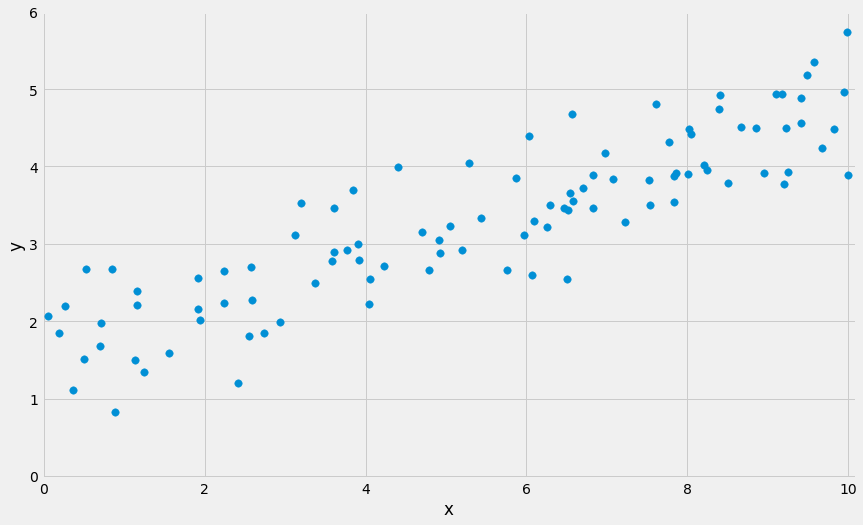

In [54]:
boring_line = Line('blue', 0.1, 0)
plot_points()
#plot_points(lines=[boring_line])

In [209]:
def show_cost(Line):
    if not Line.cost:
        Line.cost = score(Line)
    print("cost:", round(Line.cost,2), "\n")

In [214]:
def gradient_descent(starting_line, learning_rate, iterations,
                     new_color='cyan',
                     sleep=None,
                     verbose=False):
    
    yi = starting_line.y_intercept
    s = starting_line.slope
    n = int(len(x))
    all_lines = []
    
    if not starting_line.cost:
        starting_line.cost = score(starting_line)
    all_lines.append(starting_line)
    
    if verbose:
        echo_every_x_iters = int(iterations/10)
    
    for i in range(iterations): 
        y_pred = s*x + yi  # Output of this line's function for this x value
        D_s = (-2/n) * sum(x * (y - y_pred))
        D_yi = (-2/n) * sum(y - y_pred) 
        s = s - learning_rate * D_s  # Update slope
        yi = yi - learning_rate * D_yi  # Update y-intercept
        
        iter_line = Line(color=starting_line.color, y_intercept=yi, slope=s)
        iter_line.cost = score(iter_line)
        all_lines.append(iter_line)
        
        if verbose:
            if (i+1) % echo_every_x_iters == 0:
                
                if iter_line.cost > 0.5:
                    round_digits = 2
                else:
                    round_digits = 3

                print("after", i+1, "iterations:", round(iter_line.cost, round_digits))
                if sleep:
                    time.sleep(sleep)
    
    final_line = Line(color=new_color, y_intercept=yi, slope=s)

    return final_line, all_lines

### MACHINES, I HEREBY ORDER YOU TO LEARN:

In [ ]:
learning_rate = 0.00025  # Learning rate
iterations = 25  # The number of iterations of gradient descent to do

print("\nStarting values for this line:")
show_cost(boring_line)

trained_20, training_trend_20 = gradient_descent(boring_line, 
                           learning_rate=learning_rate,
                           iterations=iterations, 
                           new_color='cyan',
                           sleep=0.25,
                           verbose=True)

print("\nFinal values for this line:")
show_cost(trained_20)

In [ ]:
plot_points(lines=[boring_line, trained_20])

### TIME FOR MORE LEARNING

In [ ]:
iterations = 100

print("\nStarting values for this line:")
show_cost(boring_line)

trained_100, training_trend_100 = gradient_descent(boring_line,
                               learning_rate=learning_rate,
                               iterations=iterations,
                               new_color='green',
                               verbose=True)

In [ ]:
plot_points(lines=[boring_line, trained_20, trained_100])

We can watch how the line moves to fit better over the course of training too:

In [ ]:
# Import pre-rendered video
#video_path = "img/train100.mp4"
video_path = "https://iai-images.s3-us-west-2.amazonaws.com/m3_sf_2020/train100.mp4"

if IN_COLAB:
    display(HTML("""
    <video width=1000 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % video_path))

else:
    display(Video(video_path))

We can also look at how the cost changes during training:

In [ ]:
def plot_trend(training_trend):
    cost_values = [i.cost for i in training_trend]
    plt.figure(figsize=FIGSIZE)
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.plot(cost_values)
    plt.axis((None, None, -0.02, max(cost_values) + 0.1)) #xmin, xmax, ymin, ymax
    plt.show()
    
plot_trend(training_trend_100[0:])

### WHAT IF WE WENT TOTALLY CRAZY WITH LEARNING?
### JUST SO MUCH LEARNING THERE SHOULD BE A LAW AGAINST IT?

In [223]:
iterations = 1000

print("\nStarting values for this line:")
show_cost(boring_line)

trained_1000, training_trend_1000 = gradient_descent(boring_line,
                               learning_rate=learning_rate,
                               iterations=iterations,
                               new_color='orange')

print("\nFinal values for this line:")
show_cost(trained_1000)

In [ ]:
plot_points(lines=[boring_line, trained_20, trained_100, trained_1000])

In [ ]:
plot_trend(training_trend_1000[0:])

In [90]:
# appendix


# Export to png for animation.
# Watch out, generates lots of files.

def export_pngs(trend, sample_every=None):
    
    def export(line, incr):
        savefile = "train_{:05}.png".format(incr)
        plot_points(lines=[i], savefile=savefile)
        
    
    itercount = 0
    for i in trend:
        # ffmpeg requires no gaps in image numbering sequence, so use 'itercount' if sampling, rather than enumerating the list
        if sample_every:
            # export only once every N epochs
            export(i, itercount)
            itercount += 1
            print(itercount, end=", ")
            
        else:
            # export all epochs
            export(i, itercount)
            itercount += 1
            if n % 5 == 0:
                print(itercount, end=", ")

    print()

# Uncomment to export:
#export_pngs(training_trend_100) #, sample_every=7)

## Then stitch to video with ffmpeg on the command line:
## ffmpeg -framerate 20 -i train_%05d.png train100.mp4

